In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from google.colab import drive

drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Datasets')
!ls

#plt.ion()   # interactive mode

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
chest_xray  ChestXRay2017.zip  chest_xray_weights


In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ColorJitter(brightness=0, contrast=0, saturation=1, hue=.4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.ColorJitter(brightness=0, contrast=0, saturation=1, hue=.4),
        transforms.CenterCrop(224),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'chest_xray'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

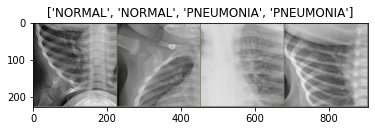

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [0]:
model_ft = models.vgg19(pretrained=False)
model_ft.classifier[6] = nn.Linear(4096,2)


model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [0]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.5638 Acc: 0.7417
val Loss: 0.5865 Acc: 0.6250

Epoch 1/24
----------
train Loss: 0.4814 Acc: 0.7720
val Loss: 0.4808 Acc: 0.7452

Epoch 2/24
----------
train Loss: 0.3907 Acc: 0.8163
val Loss: 0.4699 Acc: 0.7596

Epoch 3/24
----------
train Loss: 0.3553 Acc: 0.8388
val Loss: 0.4085 Acc: 0.8093

Epoch 4/24
----------
train Loss: 0.3199 Acc: 0.8609
val Loss: 0.5585 Acc: 0.7516

Epoch 5/24
----------
train Loss: 0.2993 Acc: 0.8710
val Loss: 0.3767 Acc: 0.8397

Epoch 6/24
----------
train Loss: 0.2771 Acc: 0.8777
val Loss: 0.4000 Acc: 0.8317

Epoch 7/24
----------
train Loss: 0.2701 Acc: 0.8789
val Loss: 0.4563 Acc: 0.8029

Epoch 8/24
----------
train Loss: 0.2576 Acc: 0.8888
val Loss: 0.4309 Acc: 0.8157

Epoch 9/24
----------
train Loss: 0.2626 Acc: 0.8846
val Loss: 0.4058 Acc: 0.8446

Epoch 10/24
----------
train Loss: 0.2562 Acc: 0.8901
val Loss: 0.4291 Acc: 0.8285

Epoch 11/24
----------
train Loss: 0.2565 Acc: 0.8890
val Loss: 0.3862 Acc: 0.8429

Epoch 12/24
----------
t

In [0]:
visualize_model(model_ft)
torch.save(model_ft,'chest_weights_VGG19_full.pth')

Training only the convenet




In [0]:
model_conv = torchvision.models.vgg19(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
model_conv.classifier[6] = nn.Linear(4096,2)


model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.classifier[6].parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [0]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=100)

Epoch 0/99
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.9040 Acc: 0.7814
val Loss: 0.7758 Acc: 0.8093

Epoch 1/99
----------
train Loss: 0.9678 Acc: 0.7966
val Loss: 0.8357 Acc: 0.7837

Epoch 2/99
----------
train Loss: 1.0146 Acc: 0.7936
val Loss: 0.5521 Acc: 0.8125

Epoch 3/99
----------
train Loss: 0.9916 Acc: 0.8085
val Loss: 0.6130 Acc: 0.8205

Epoch 4/99
----------
train Loss: 1.0823 Acc: 0.8014
val Loss: 2.2754 Acc: 0.6683

Epoch 5/99
----------
train Loss: 1.0079 Acc: 0.8075
val Loss: 0.9911 Acc: 0.8029

Epoch 6/99
----------
train Loss: 0.8553 Acc: 0.8169
val Loss: 0.7113 Acc: 0.8349

Epoch 7/99
----------
train Loss: 0.7638 Acc: 0.8224
val Loss: 0.7409 Acc: 0.8077

Epoch 8/99
----------
train Loss: 0.6833 Acc: 0.8264
val Loss: 0.5537 Acc: 0.8317

Epoch 9/99
----------
train Loss: 0.6405 Acc: 0.8323
val Loss: 0.4690 Acc: 0.8397

Epoch 10/99
----------
train Loss: 0.5797 Acc: 0.8356
val Loss: 0.4582 Acc: 0.8429

Epoch 11/99
----------
train Loss: 0.5916 Acc: 0.8256
val Loss: 0.5092 Acc: 0.8333

Epoch 12/99
----------
t

In [0]:
visualize_model(model_conv)

#torch.save(model_conv,'chest_weights_VGG19_transfer.pth')
plt.ioff()
plt.show()